In [1]:
from __future__ import division

import os
import time
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import gc
from IPython.display import clear_output
from collections import namedtuple, deque
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec, Conv2D, Conv2DTranspose, Activation, Input, UpSampling2D, Dropout, Concatenate, add
from tensorflow.keras import initializers, regularizers, constraints, Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# From keras-contrib. Since I am using Windows OS, I cannot use tensorflow addons currently
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
class ImageBuffer:
    """Fixed-size buffer to store image tuples."""

    def __init__(self, buffer_size):
        """Initialize a ImageBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.images = namedtuple("Images", field_names=['real_image_X', 'fake_image_X', 
                                                        'real_image_Y', 'fake_image_Y'])
    
    def add(self, real_image_X, fake_image_X, real_image_Y, fake_image_Y):
        """Add a new images to memory."""
        image_pair = self.images(real_image_X, fake_image_X, real_image_Y, fake_image_Y)
        self.memory.append(image_pair)
    
    def sample(self):
        """Return a batch of image tuples from memory."""
        return self.memory.popleft()

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Model components

In [5]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    '''
        From: https://stackoverflow.com/questions/50677544/reflection-padding-conv2d
        jeevaa_v's answer
    '''
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        '''If you are using "channels_last" configuration'''
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

class ConvBlock(tf.keras.Model):
    '''
        Convolution-InstanceNorm-ReLU, denoted as d in the original paper
    '''
    def __init__(self, filters, kernel_size=7, strides=1, padding='valid', activation=tf.nn.relu):
        super(ConvBlock, self).__init__(name='')
        self.blocks = Sequential([Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                                        InstanceNormalization(axis=-1, epsilon=1e-5, center=False, scale=False),
                                        Activation(activation)])
    
    def call(self, input_tensor):
        x = self.blocks(input_tensor)
        return x

class DeConvBlock(tf.keras.Model):
    '''
        fractional-strided-ConvolutionInstanceNorm-ReLU, denoted as u in the original paper
    '''
    def __init__(self, filters, kernel_size=7, strides=1, padding='valid', activation=tf.nn.relu):
        super(DeConvBlock, self).__init__(name='')
        self.blocks = Sequential([Conv2DTranspose(filters, kernel_size, strides, padding=padding, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                                    InstanceNormalization(axis=-1, epsilon=1e-5, center=False, scale=False),
                                    Activation(activation)])
    
    def call(self, input_tensor):
        x = self.blocks(input_tensor)
        return x
    
class ResidualBlock(tf.keras.Model):
    '''
        Residual block with two 3x3 conv layer, denoted as R in the original paper
    '''
    def __init__(self, filters, kernel_size=3, strides=1, padding='valid', activation=tf.nn.relu):
        super(ResidualBlock, self).__init__(name='')
        self.conv_blocks = Sequential([Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                                            ReflectionPadding2D((1, 1)),
                                            InstanceNormalization(axis=-1, epsilon=1e-5, center=False, scale=False),
                                            Activation(activation),
                                            Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                                            ReflectionPadding2D((1, 1)),
                                            InstanceNormalization(axis=-1, epsilon=1e-5, center=False, scale=False)])
    
    def call(self, input_tensor):
        x = self.conv_blocks(input_tensor)
        x = add([x, input_tensor])
        return x
    
def create_cyclegan_generator(input_shape, n_blocks=9, name=''):
    '''
        Resnet generator
    '''
    input_tensor = Input(input_shape)
    ''' c7s1-k '''
    x = ReflectionPadding2D((3, 3))(input_tensor)
    x = ConvBlock(filters=64, kernel_size=7, strides=1, activation=tf.nn.leaky_relu)(x)
    
    ''' Downsampling blocks '''
    x = ConvBlock(filters=128, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)(x)
    x = ConvBlock(filters=256, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)(x)
    
    ''' Residual blocks '''
    for i in range(n_blocks):
        x = ResidualBlock(256, kernel_size=3, strides=1, activation=tf.nn.leaky_relu)(x)
    
    ''' Upsampling blocks '''
    x = DeConvBlock(filters=128, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)(x)
    x = DeConvBlock(filters=64, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)(x)
    
    ''' Output blocks '''
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=3, kernel_size=7, strides=1, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    if len(name) > 0:
        output = Activation('tanh', name='{}_output'.format(name))(x)
        model = Model(inputs=input_tensor, outputs=output, name=name)
    else:
        output = Activation('tanh')(x)
        model = Model(inputs=input_tensor, outputs=output)
    
    return model

def create_cyclegan_discriminator(input_shape, name=''):
    '''
        70 × 70 PatchGAN, 70 x 70 means the receptive field of conv model
        Check here for more info. https://fomoro.com/research/article/receptive-field-calculator
    '''
    input_tensor = Input(input_shape)
    x = Conv2D(filters=64, kernel_size=4, strides=2, padding='valid',
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_tensor)
    x = Activation(tf.nn.leaky_relu)(x)
    
    x = ConvBlock(filters=128, kernel_size=4, strides=2, padding='valid', activation=tf.nn.leaky_relu)(x)
    x = ConvBlock(filters=256, kernel_size=4, strides=2, padding='valid', activation=tf.nn.leaky_relu)(x)
    x = ConvBlock(filters=512, kernel_size=4, strides=1, padding='same', activation=tf.nn.leaky_relu)(x)
    
    if len(name) > 0:
        output = Conv2D(filters=1, kernel_size=4, strides=1, padding='same',
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)
                        , name='{}_output'.format(name))(x)
        model = Model(inputs=input_tensor, outputs=output, name=name)
    else:
        output = Conv2D(filters=1, kernel_size=4, strides=1, padding='same',
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        model = Model(inputs=input_tensor, outputs=output)
    
    return model

## Hyper Parameters & Setting

In [6]:
INPUT_SHAPE = (256, 256, 3)
SCALE_WIDTH = 256
DATASET = 'monet2photo'
DATASET_PATH = os.path.join("datasets", DATASET) # Dataset path
OUTPUT_PATH = 'outputs'
train_logdir = os.path.join("logs", "tensorflow", 'train_data') # Sets up a log directory.
test_logdir = os.path.join("logs", "tensorflow", 'test_data') # Sets up a log directory.

USE_BUFFER = True # Use image buffer to train discriminator
REPLAY_PROB = 0.5 # The probability of using previous fake images to train discriminator
BUFFER_SIZE = 50 # The maximum size of image buffer
BATCH_SIZE = 1

EPOCHs = 200
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 5 # Save checkpoint at every n epoch

DISCRIMINATOR_LOSS_WEIGHT = 0.5 # Discriminator loss will be multiplied by this weight
SOFT_FAKE_LABEL_RANGE = [0.0, 0.3] # The label of fake label will be generated within this range.
SOFT_REAL_LABEL_RANGE = [0.7, 1.2] # The label of real label will be generated within this range.
LR = 0.0002
LR_DECAY_EPOCH = 100
LAMBDA = 10 # loss weight for cycle consistency

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(train_logdir)
test_file_writer = tf.summary.create_file_writer(test_logdir)

## Build models

In [7]:
# The original paper using 9 residual blocks to train monet to photo dataset
G_XtoY = create_cyclegan_generator(INPUT_SHAPE, n_blocks=9, name='G_XtoY')
G_YtoX = create_cyclegan_generator(INPUT_SHAPE, n_blocks=9, name='G_YtoX')

In [8]:
G_XtoY.summary()

Model: "G_XtoY"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
reflection_padding2d (Reflec (None, 262, 262, 3)       0         
_________________________________________________________________
conv_block (ConvBlock)       (None, 256, 256, 64)      9472      
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 128, 128, 128)     73856     
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 64, 64, 256)       295168    
_________________________________________________________________
residual_block (ResidualBloc (None, 64, 64, 256)       1180160   
_________________________________________________________________
residual_block_1 (ResidualBl (None, 64, 64, 256)       11801

In [9]:
Dx = create_cyclegan_discriminator(INPUT_SHAPE, name='Dx')
Dy = create_cyclegan_discriminator(INPUT_SHAPE, name='Dy')

In [10]:
Dx.summary()

Model: "Dx"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 127, 127, 64)      3136      
_________________________________________________________________
activation_28 (Activation)   (None, 127, 127, 64)      0         
_________________________________________________________________
conv_block_6 (ConvBlock)     (None, 62, 62, 128)       131200    
_________________________________________________________________
conv_block_7 (ConvBlock)     (None, 30, 30, 256)       524544    
_________________________________________________________________
conv_block_8 (ConvBlock)     (None, 30, 30, 512)       2097664   
_________________________________________________________________
Dx_output (Conv2D)           (None, 30, 30, 1)         8193     

## Image preprocessing function

In [11]:
# From: https://www.tensorflow.org/tutorials/generative/cyclegan
def random_crop(image):
    cropped_image = tf.image.random_crop(
                image, size=[BATCH_SIZE, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]])
    return cropped_image

def normalize(image):
    '''
        normalizing the images to [-1, 1]
    '''
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
#     image = tf.image.resize(image, [int(aspect_ratio * SCALE_WIDTH), SCALE_WIDTH],
#                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(images, label):
    images = random_jitter(images)
    images = normalize(images)
    return images

def preprocess_image_test(images, label):
    images = normalize(images)
    return images

## Create image data loader

In [12]:
train_datagen_X = ImageDataGenerator().flow_from_directory(
                                                DATASET_PATH,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                classes=['trainA'],
                                                )
train_datagen_Y = ImageDataGenerator().flow_from_directory(
                                                DATASET_PATH,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                classes=['trainB'])
test_datagen_X = ImageDataGenerator().flow_from_directory(
                                                DATASET_PATH,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                classes=['testA'])
test_datagen_Y = ImageDataGenerator().flow_from_directory(
                                                DATASET_PATH,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                classes=['testB'])

train_image_generator_X = tf.data.Dataset.from_generator(lambda: train_datagen_X, output_types=(tf.int32, tf.int32))
train_image_generator_Y = tf.data.Dataset.from_generator(lambda: train_datagen_Y, output_types=(tf.int32, tf.int32))
test_image_generator_X = tf.data.Dataset.from_generator(lambda: test_datagen_X, output_types=(tf.int32, tf.int32))
test_image_generator_Y = tf.data.Dataset.from_generator(lambda: test_datagen_Y, output_types=(tf.int32, tf.int32))

train_image_generator_X = train_image_generator_X.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE)

train_image_generator_Y = train_image_generator_Y.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE)

test_image_generator_X = test_image_generator_X.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE)

test_image_generator_Y = test_image_generator_Y.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE)

Found 1072 images belonging to 1 classes.
Found 6287 images belonging to 1 classes.
Found 121 images belonging to 1 classes.
Found 751 images belonging to 1 classes.


In [13]:
train_image_generator_X = iter(train_image_generator_X)
train_image_generator_Y = iter(train_image_generator_Y)
test_image_generator_X = iter(test_image_generator_X)
test_image_generator_Y = iter(test_image_generator_Y)

## Check images

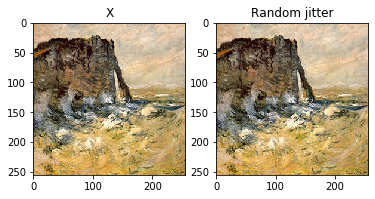

In [14]:
sample_X = next(train_image_generator_X)
sample_Y = next(train_image_generator_Y)
plt.subplot(121)
plt.title('X')
plt.imshow(sample_X[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random jitter')
plt.imshow(random_jitter(sample_X)[0] * 0.5 + 0.5)

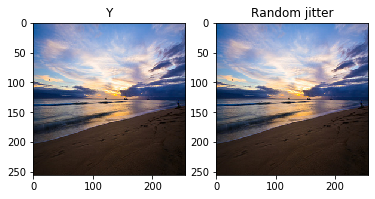

In [15]:
plt.subplot(121)
plt.title('Y')
plt.imshow(sample_Y[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random jitter')
plt.imshow(random_jitter(sample_Y)[0] * 0.5 + 0.5)

In [16]:
image_buffer = ImageBuffer(buffer_size=BUFFER_SIZE)

In [17]:
training_steps = min(len(train_datagen_X), len(train_datagen_Y))

In [18]:
print(training_steps)

1072


## Optimizers

In [19]:
Dx_optimizer = Adam(learning_rate=LR, beta_1=0.5)
Dy_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_XtoY_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_YtoX_optimizer = Adam(learning_rate=LR, beta_1=0.5)

def calculate_learning_rate(epoch, current_lr):
    '''
        From https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
    '''
    decay = 1.0 - max(0, epoch + 1 - LR_DECAY_EPOCH) / float(LR_DECAY_EPOCH + 1)
    return current_lr * decay

def set_learning_rate(new_lr):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(Dx_optimizer.lr, new_lr)
    K.set_value(Dy_optimizer.lr, new_lr)
    K.set_value(G_XtoY_optimizer.lr, new_lr)
    K.set_value(G_YtoX_optimizer.lr, new_lr)

## Losses

![losses](notebook_images/losses.jpg)

Losses, take domain X->Y for example

Discriminator Y loss

$$D_{y}\ fake = \frac{1}{m}\sum_{i = 1}^{m}\left ( D_{y}(G_{x\to y}(x))\right )^{2}$$

$$D_{y}\ real = \frac{1}{m}\sum_{i = 1}^{m}\left ( D_{y}(y) - 1\right )^{2}$$

$$Total\ D_{y}\ loss: D_{y}\ fake + D_{y}\ real$$

Cycle consistency loss

$$\textit{L}_{cyc} = \frac{1}{m}\sum_{i = 1}^{m}\left \| G_{y\to x}(G_{x\to y}(x)) - x \right \| + \frac{1}{m}\sum_{i = 1}^{m}\left \| G_{x\to y}(G_{y\to x}(y)) - y \right \|$$

Identity loss

$$\textit{L}_{identity} = \frac{1}{m}\sum_{i = 1}^{m}\left \| (G_{x\to y}(y) - y \right \|$$

Generator loss

$$G_{x\to y}\ loss = \frac{1}{m}\sum_{i = 1}^{m}\left ( Dy(G_{x\to y}(x)) - 1 \right )^{2} + \lambda \textit{L}_{cyc} + 0.5 \lambda \textit{L}_{identity}$$

In [20]:
def discriminator_loss(real_image, generated_image):
    real_loss = tf.reduce_mean(tf.square(real_image - tf.random.uniform(tf.shape(real_image),
                                                                        minval=SOFT_REAL_LABEL_RANGE[0],
                                                                        maxval=SOFT_REAL_LABEL_RANGE[1])))
    fake_loss = tf.reduce_mean(tf.square(generated_image - tf.random.uniform(tf.shape(generated_image),
                                                                        minval=SOFT_FAKE_LABEL_RANGE[0],
                                                                        maxval=SOFT_FAKE_LABEL_RANGE[1])))
    total_loss = real_loss + fake_loss
    #  Slow down discriminators' learning pace
    return total_loss * DISCRIMINATOR_LOSS_WEIGHT

def generator_loss(generated_image):
    loss =tf.reduce_mean(tf.square(generated_image - tf.random.uniform(tf.shape(generated_image),
                                                                        minval=SOFT_REAL_LABEL_RANGE[0],
                                                                        maxval=SOFT_REAL_LABEL_RANGE[1])))
    return loss

def cycle_consistency_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(cycled_image - real_image))
    return loss * LAMBDA

def identity_loss(real_image, generated_image):
    loss =tf.reduce_mean(tf.abs(generated_image - real_image))
    return loss * 0.5 * LAMBDA

## Restore checkpoint if exists

In [21]:
checkpoint_path = os.path.join("checkpoints", "tensorflow", DATASET)

ckpt = tf.train.Checkpoint(G_XtoY=G_XtoY,
                           G_YtoX=G_YtoX,
                           Dx=Dx,
                           Dy=Dy,
                           G_XtoY_optimizer=G_XtoY_optimizer,
                           G_YtoX_optimizer=G_YtoX_optimizer,
                           Dx_optimizer=Dx_optimizer,
                           Dy_optimizer=Dy_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 25 restored!!


## Saving image functions

In [22]:
def generate_images(model, test_input, img_name='img', step=0, file_writer=None, show_result=False):
    '''
        Generate images and save them to tensorboard
    '''
    prediction = model.predict_on_batch(test_input)
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    if file_writer != None:
        # Using the file writer, log the reshaped image.
        with file_writer.as_default():
            tf.summary.image(img_name, prediction * 0.5 + 0.5, step=step)
            file_writer.flush()
            print("Writing image done")
    
    if show_result:
        plt.figure(figsize=(12, 12))
        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()
        
def generate_test_images(model1, model2, test_input, img_name='img', step=0, file_writer=None, show_result=False):
    '''
        Generate images and cycled images, then save them to tensorboard
    '''
    prediction1 = model1.predict_on_batch(test_input)
    prediction2 = model2.predict_on_batch(prediction1)

    display_list = [test_input[0], prediction1[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Cycled Image']
    
    if file_writer != None:
        # Using the file writer, log the reshaped image.
        with file_writer.as_default():
            tf.summary.image(img_name + ' original', test_input * 0.5 + 0.5, step=step)
            tf.summary.image(img_name + ' predicted', prediction1 * 0.5 + 0.5, step=step)
            tf.summary.image(img_name + ' cycled', prediction2 * 0.5 + 0.5, step=step)
            file_writer.flush()
    
    if show_result:
        plt.figure(figsize=(12, 12))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()
        
def save_test_images(model1, model2, test_input, folder_name='img', step=0, save=False, show_result=False):
    '''
        Generate images and cycled images, then save them as jpg
    '''
    prediction1 = model1.predict_on_batch(test_input)
    prediction2 = model2.predict_on_batch(prediction1)

    display_list = [test_input[0], prediction1[0], prediction2[0]]
    title = ['original', 'predicted', 'cycled']
    figure_title = ['Input Image', 'Predicted Image', 'Cycled Image']
    
    base_folder = os.path.join(OUTPUT_PATH, folder_name)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    
    if save:
        for img, title in zip(display_list, title):
            save_folder = os.path.join(base_folder, title)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            img = np.array(img * 0.5 + 0.5)
            plt.imsave(os.path.join(save_folder, '{}.jpg'.format(step)), img)
            
    if show_result:
        plt.figure(figsize=(12, 12))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(figure_title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

## Define training step using tf.function

In [23]:
@tf.function
def train_d_step(real_X, real_Y,
               fake_X, fake_Y, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/cyclegan
    '''
    print("trace graph")
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape(persistent=True) as d_tape:
        # Compute the discriminator loss using buffered images
        Dx_real = Dx(real_X, training=True)
        Dx_fake = Dx(fake_X, training=True)

        Dy_real = Dy(real_Y, training=True)
        Dy_fake = Dy(fake_Y, training=True)
        
        Dx_loss = discriminator_loss(Dx_real, Dx_fake)
        Dy_loss = discriminator_loss(Dy_real, Dy_fake)
          
    # Calculate the gradients for and discriminator
    Dx_gradients = d_tape.gradient(Dx_loss, 
                                            Dx.trainable_variables)
    
    Dy_gradients = d_tape.gradient(Dy_loss, 
                                            Dy.trainable_variables)

    # Apply the gradients to the optimizer
    Dx_optimizer.apply_gradients(zip(Dx_gradients,
                                                Dx.trainable_variables))
  
    Dy_optimizer.apply_gradients(zip(Dy_gradients,
                                                Dy.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 50 == 0:
        with file_writer.as_default():
            tf.summary.scalar('Dx_loss', Dx_loss, step=step)
            tf.summary.scalar('Dy_loss', Dy_loss, step=step)

@tf.function
def train_g_step(real_image_X, real_image_Y, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/cyclegan
    '''
    #print("trace graph")
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape(persistent=True) as g_tape:
        fake_image_X = G_YtoX(real_image_Y, training=True)
        fake_image_Y = G_XtoY(real_image_X, training=True)
        # same_image_X and same_image_Y are used for identity loss.
        same_image_X = G_YtoX(real_image_X, training=True)
        same_image_Y = G_XtoY(real_image_Y, training=True)
        
        # Compute the generator loss
        G_XtoY_loss = generator_loss(Dy(fake_image_Y, training=True))
        G_YtoX_loss = generator_loss(Dx(fake_image_X, training=True))

        # Compute the cycle consistency loss
        cycled_XtoYtoX = G_YtoX(fake_image_Y, training=True)
        cycled_YtoXtoY = G_XtoY(fake_image_X, training=True)
        cycled_XtoY_loss = cycle_consistency_loss(real_image_X, cycled_XtoYtoX)
        cycled_YtoX_loss = cycle_consistency_loss(real_image_Y, cycled_YtoXtoY)
        total_cycle_loss = cycled_XtoY_loss + cycled_YtoX_loss
        
        # Compute the identity loss
        identity_loss_for_XtoY = identity_loss(real_image_Y, same_image_Y)
        identity_loss_for_YtoX = identity_loss(real_image_X, same_image_X)
        
        
        # Combine all losses
        total_G_XtoY_loss = G_XtoY_loss + total_cycle_loss + identity_loss_for_XtoY
        total_G_YtoX_loss = G_YtoX_loss + total_cycle_loss + identity_loss_for_YtoX
          
    # Calculate the gradients for generator and discriminator
    G_XtoY_gradients = g_tape.gradient(total_G_XtoY_loss, 
                                        G_XtoY.trainable_variables)
    G_YtoX_gradients = g_tape.gradient(total_G_YtoX_loss, 
                                        G_YtoX.trainable_variables)

    # Apply the gradients to the optimizer
  
    G_XtoY_optimizer.apply_gradients(zip(G_XtoY_gradients,
                                                G_XtoY.trainable_variables))
  
    G_YtoX_optimizer.apply_gradients(zip(G_YtoX_gradients,
                                                G_YtoX.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 50 == 0:
        with file_writer.as_default():
            tf.summary.scalar('total_G_XtoY_loss', total_G_XtoY_loss, step=step)
            tf.summary.scalar('total_G_YtoX_loss', total_G_YtoX_loss, step=step)

In [24]:
print(tf.autograph.to_code(train_d_step.python_function))

def tf__train_d_step(real_X, real_Y, fake_X, fake_Y, step):
  """
    One discriminator training step

    Reference: https://www.tensorflow.org/tutorials/generative/cyclegan
"""
  with ag__.FunctionScope('train_d_step', 'train_d_step_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as train_d_step_scope:
    print('trace graph')
    with tf.GradientTape(persistent=True) as d_tape:
      Dx_real = ag__.converted_call(Dx, train_d_step_scope.callopts, (real_X,), {'training': True}, train_d_step_scope)
      Dx_fake = ag__.converted_call(Dx, train_d_step_scope.callopts, (fake_X,), {'training': True}, train_d_step_scope)
      Dy_real = ag__.converted_call(Dy, train_d_step_scope.callopts, (real_Y,), {'training': True}, train_d_step_scope)
      Dy_fake = ag__.converted_call(Dy, train_d_step_scope.callopts, (fake_Y,), {'training': True}, train_d_step_scope)
      Dx_loss = ag__.converted_call(discriminator_loss, trai

## Training

Writing image done


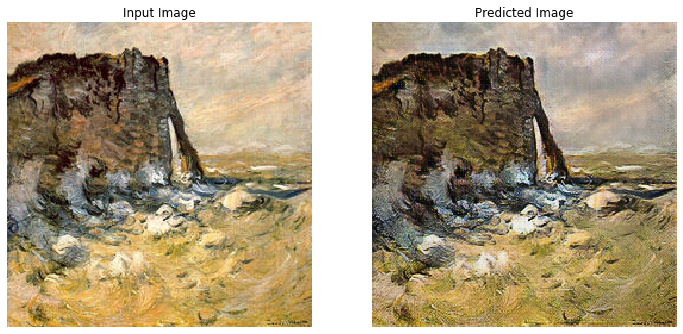

Writing image done


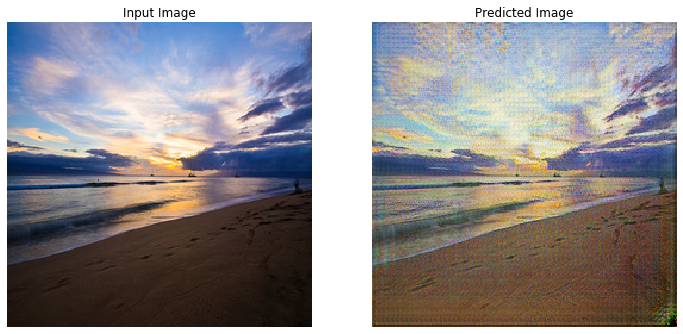

Time taken for epoch 52 is 523.9217627048492 sec

Start of epoch 53
..................................................

In [ ]:
current_learning_rate = LR
trace = True

for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = calculate_learning_rate(epoch, current_learning_rate)
    set_learning_rate(current_learning_rate)

    for step in range(training_steps):
        # Get images
        real_image_X = train_image_generator_X.next()
        real_image_Y = train_image_generator_Y.next()   
        
        # Generate fake images
        fake_image_X = G_YtoX.predict_on_batch(real_image_Y)
        fake_image_Y = G_XtoY.predict_on_batch(real_image_X)
        image_buffer.add(real_image_X, fake_image_X, real_image_Y, fake_image_Y)
        
        # To determine whether to use replay image in this training step
        replay_previous = True if REPLAY_PROB > random.random() else False
        # Use buffer only when it has more than 1 set of images
        buffer_greater_than_1 = True if len(image_buffer) > 1 else False
        
        use_buffer = USE_BUFFER and replay_previous and buffer_greater_than_1
        
        if use_buffer:
            # Get previous generated fake images
            buffered_images = image_buffer.sample()
            real_buffer_X = tf.constant(buffered_images.real_image_X, dtype=tf.float32)
            real_buffer_Y = tf.constant(buffered_images.real_image_Y, dtype=tf.float32)
            fake_buffer_X = tf.constant(buffered_images.fake_image_X, dtype=tf.float32)
            fake_buffer_Y = tf.constant(buffered_images.fake_image_Y, dtype=tf.float32)
            train_d_step(real_buffer_X, real_buffer_Y,
                         fake_buffer_X, fake_buffer_Y,
                      step=tf.constant(step, dtype=tf.int64))
        else:
            # Use images of this training step to train discriminator
            fake_image_X = tf.constant(fake_image_X, dtype=tf.float32)
            fake_image_Y = tf.constant(fake_image_Y, dtype=tf.float32)
            # Train discriminator
            train_d_step(real_image_X, real_image_Y,
                         fake_image_X, fake_image_Y,
                      step=tf.constant(step, dtype=tf.int64))
        
        # Train generator
        train_g_step(real_image_X, real_image_Y, step=tf.constant(step, dtype=tf.int64))
        if step % 10 == 0:
            print ('.', end='')
    
    # Clear jupyter notebook cell output
    clear_output(wait=True)
    # Using a consistent image (sample_X) so that the progress of the model is clearly visible.
    generate_images(G_XtoY, sample_X, img_name='sample_X', step=epoch, file_writer=file_writer, show_result=True)
    generate_images(G_YtoX, sample_Y, img_name='sample_Y', step=epoch, file_writer=file_writer, show_result=True)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    gc.collect()

# Save when finish
ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(EPOCHs,
                                                             ckpt_save_path))

# Testing

## X -> Y and X -> Y -> X

In [ ]:
for step in tqdm(range(len(test_datagen_X))):
    real_image_X = test_image_generator_X.next()
    
    show_result = True if (step + 1) >= len(test_datagen_X) else False
    
    # Save to tensorboard
    # generate_test_images(G_XtoY, G_YtoX, real_image_X, img_name='test_XtoY', step=step, file_writer=test_file_writer, show_result=show_result)
    
    # Save image
    save_test_images(G_XtoY, G_YtoX, real_image_X, folder_name='test_XtoY', step=step, save=True, show_result=show_result)

## Y -> X and Y -> X -> Y

In [ ]:
for step in tqdm(range(len(test_datagen_Y))):
    real_image_Y = test_image_generator_Y.next()
    
    show_result = True if (step + 1) >= len(test_datagen_Y) else False
    
#     Save to tensorboard
#     generate_test_images(G_YtoX, G_XtoY, real_image_Y, img_name='test_YtoX', step=step, file_writer=test_file_writer, show_result=show_result)
    
    # Save image
    save_test_images(G_YtoX, G_XtoY, real_image_Y, folder_name='test_YtoX', step=step, save=True, show_result=show_result)